In [1]:
# This script provides a way to evaluate the performance of SAM on a dataset.
# Please checkout https://github.com/facebookresearch/segment-anything to install segment anything
import matplotlib.pyplot as plt
import numpy as np

from segment_anything import SamPredictor, sam_model_registry
from sklearn.metrics import f1_score
from tqdm import tqdm

from dataset_processing.dataset import ChuAnapath
from utils.config import load_config

config = load_config('config.toml')
model_type = config['sam']['model_type']
checkpoint_path = config['sam']['checkpoint_path']
dataset_path = config['cytomine']['dataset_path']
prompt_type = None if config['dataset']['prompt_type'] == 'None' else config['dataset']['prompt_type']
n_points = config['dataset']['n_points']
device = config['sam']['device']

dataset = ChuAnapath(dataset_path, prompt_type=prompt_type, verbose=True, n_points=n_points, to_dict=False, zoom_out=2.0)
sam = sam_model_registry[model_type](checkpoint=checkpoint_path).to(device)
predictor = SamPredictor(sam)


Loading images and masks paths...


Computing prompts...: 100%|██████████| 2630/2630 [00:08<00:00, 292.52it/s]


Done!


  0%|          | 0/2630 [00:00<?, ?it/s]

[   0.    0. 1024. 1024.]


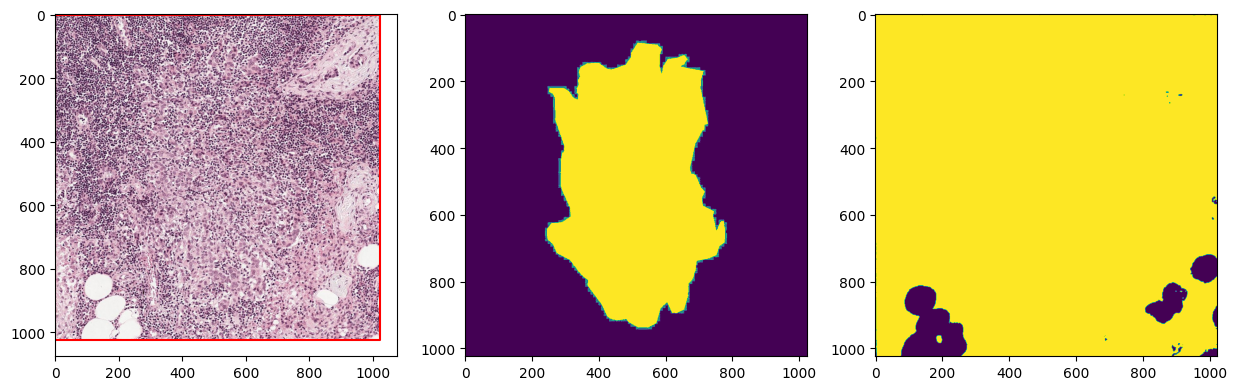

  0%|          | 1/2630 [00:01<1:09:15,  1.58s/it]

Dice score Image 0 : 0.47715033198559653
[400. 400. 624. 624.]


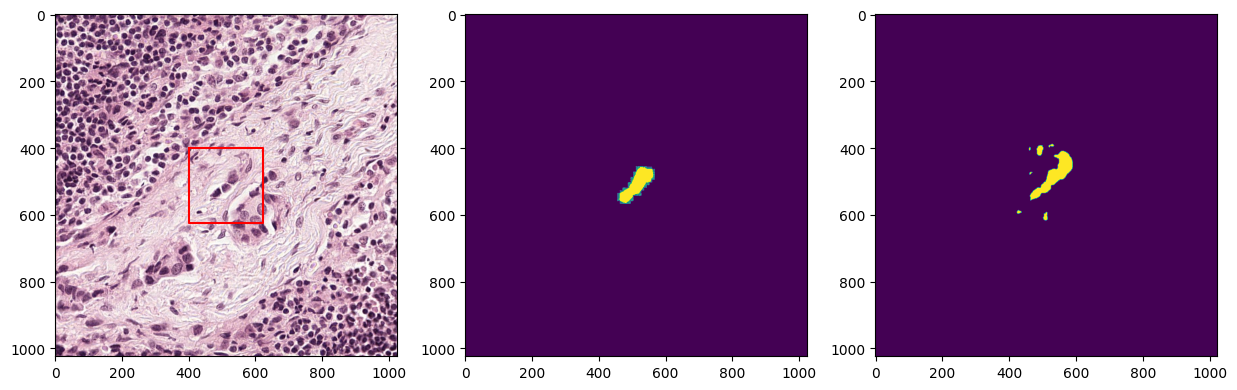

  0%|          | 2/2630 [00:02<57:02,  1.30s/it]  

Dice score Image 1 : 0.5697160883280756
[300. 352. 732. 672.]


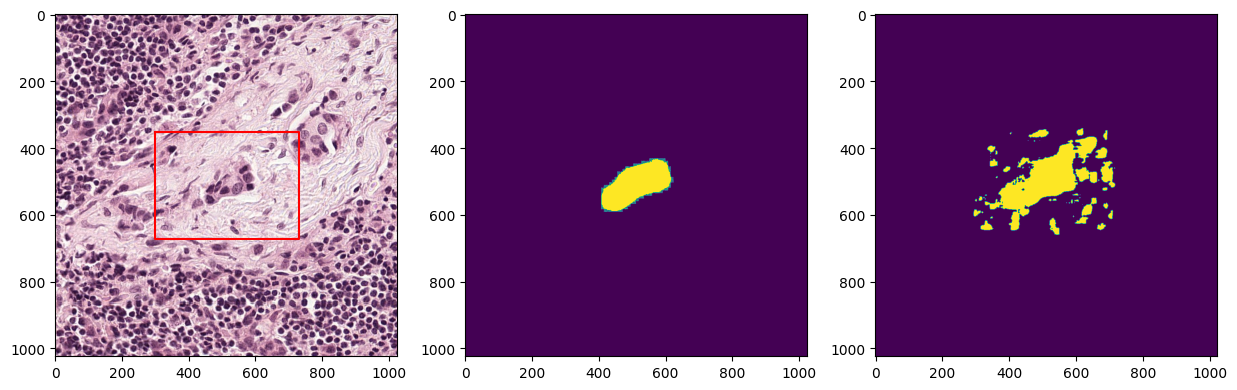

  0%|          | 3/2630 [00:03<51:08,  1.17s/it]

Dice score Image 2 : 0.5661249228529379
[368. 336. 656. 688.]


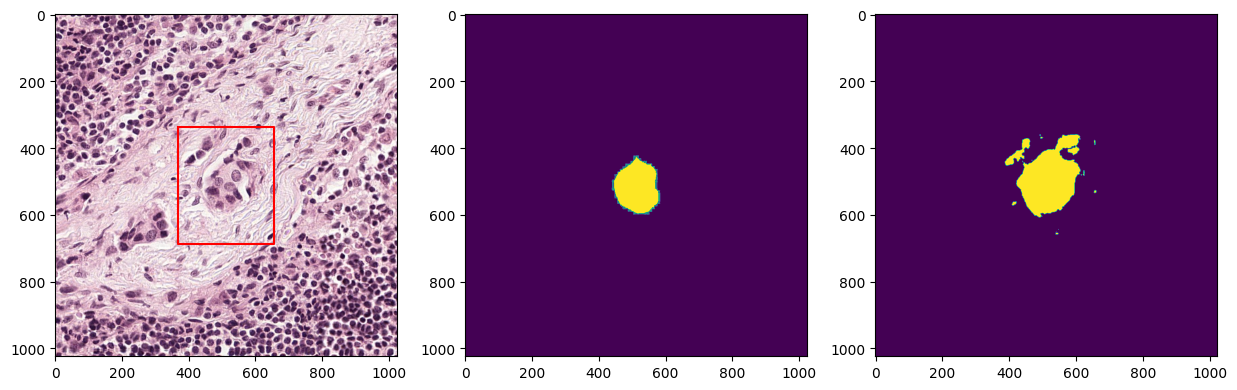

  0%|          | 4/2630 [00:04<48:21,  1.10s/it]

Dice score Image 3 : 0.6999377464204192
[   0.    0. 1024. 1024.]


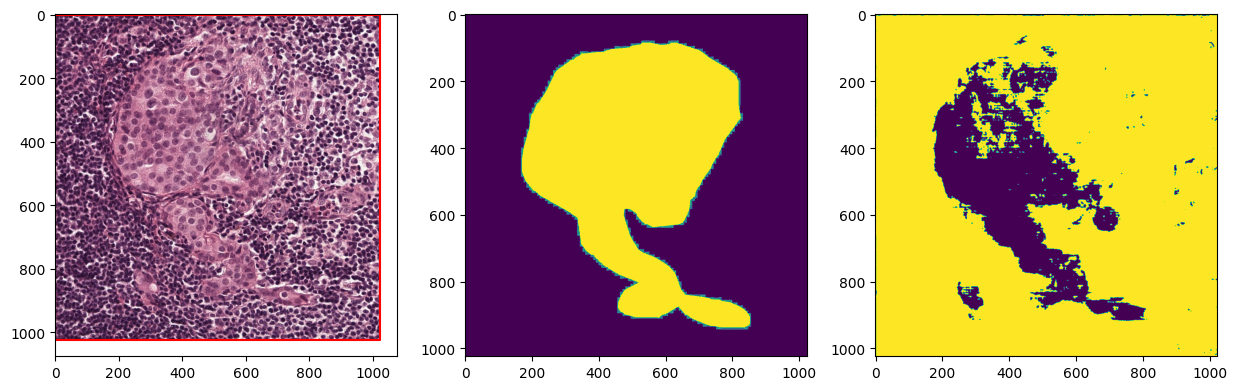

  0%|          | 5/2630 [00:05<46:46,  1.07s/it]

Dice score Image 4 : 0.29034068628060583
[336. 192. 688. 832.]


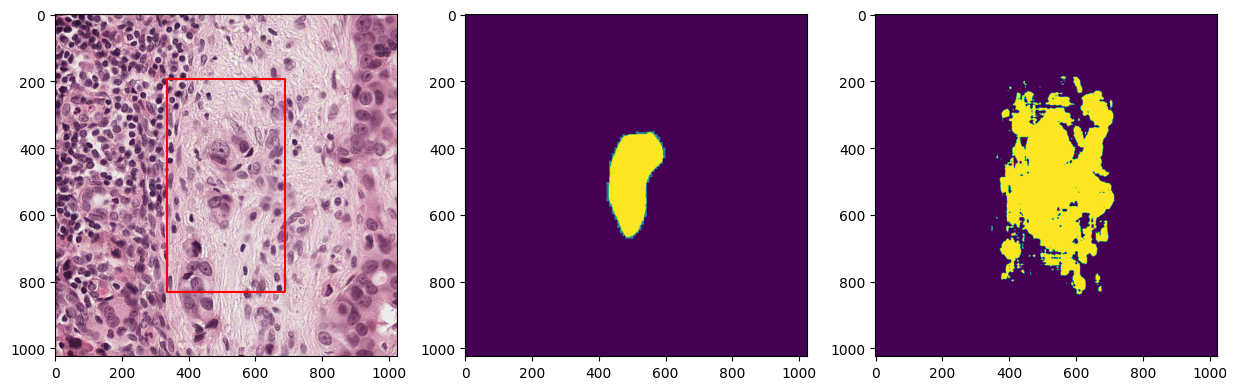

  0%|          | 6/2630 [00:06<45:44,  1.05s/it]

Dice score Image 5 : 0.4155202260868502
[ 172.    0.  860. 1024.]


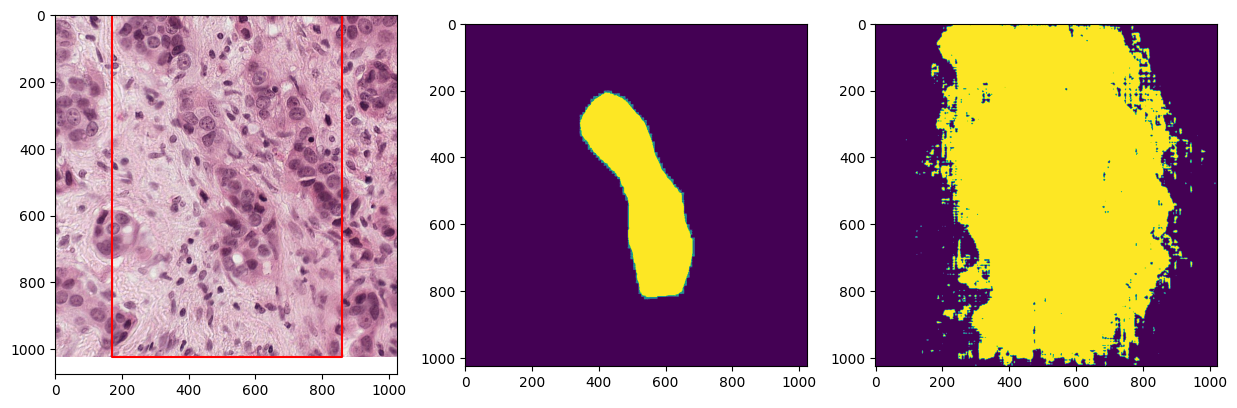

  0%|          | 7/2630 [00:07<45:07,  1.03s/it]

Dice score Image 6 : 0.29502811679685575
[ 112.    0.  912. 1024.]


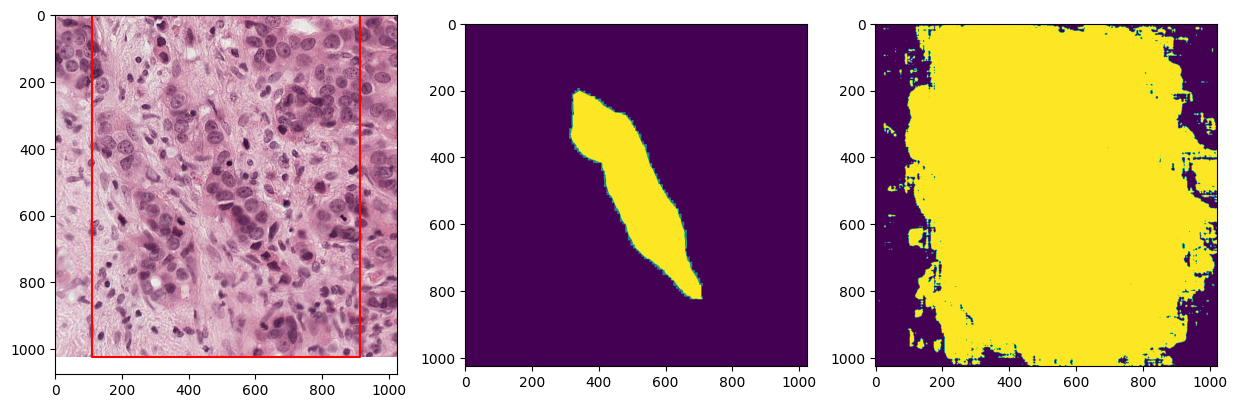

  0%|          | 8/2630 [00:08<44:54,  1.03s/it]

Dice score Image 7 : 0.200394898222958
[  80.    0.  944. 1024.]


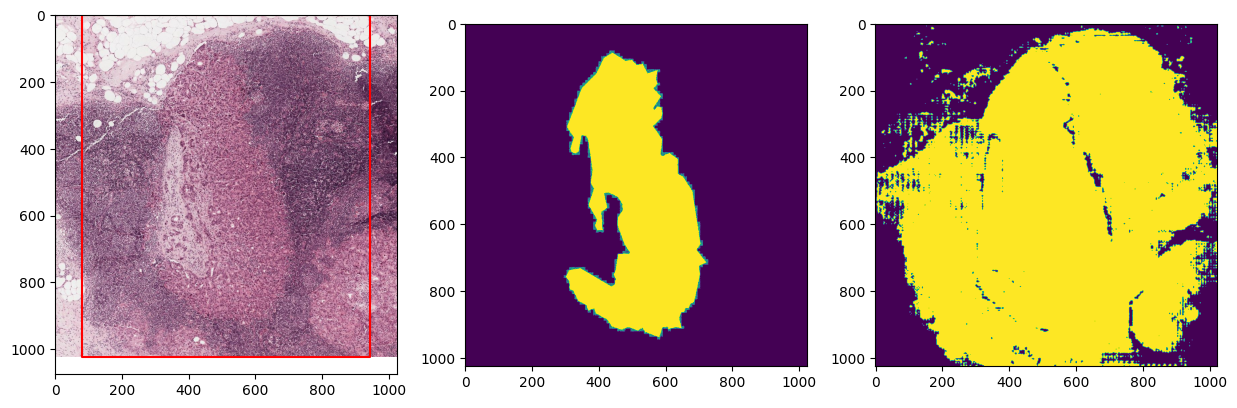

  0%|          | 9/2630 [00:09<44:44,  1.02s/it]

Dice score Image 8 : 0.4386258504395612
[   0.    0. 1024. 1024.]


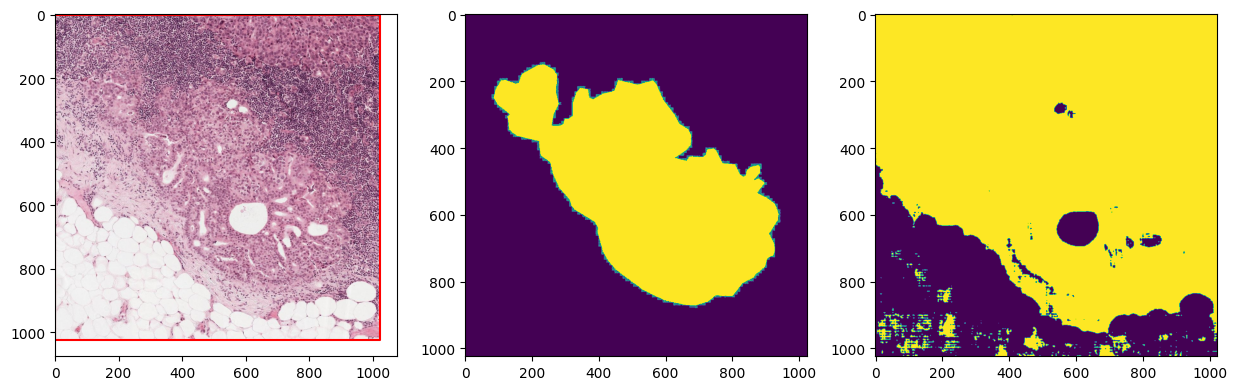

  0%|          | 10/2630 [00:10<44:33,  1.02s/it]

Dice score Image 9 : 0.5487163739422635
[368. 240. 656. 784.]


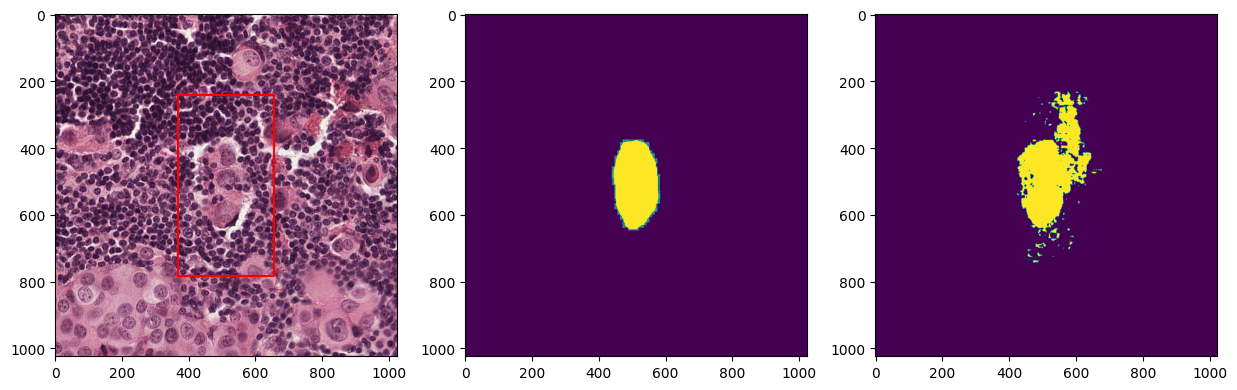

  0%|          | 11/2630 [00:11<45:52,  1.05s/it]

Dice score Image 10 : 0.722683062571224
[320. 400. 704. 624.]


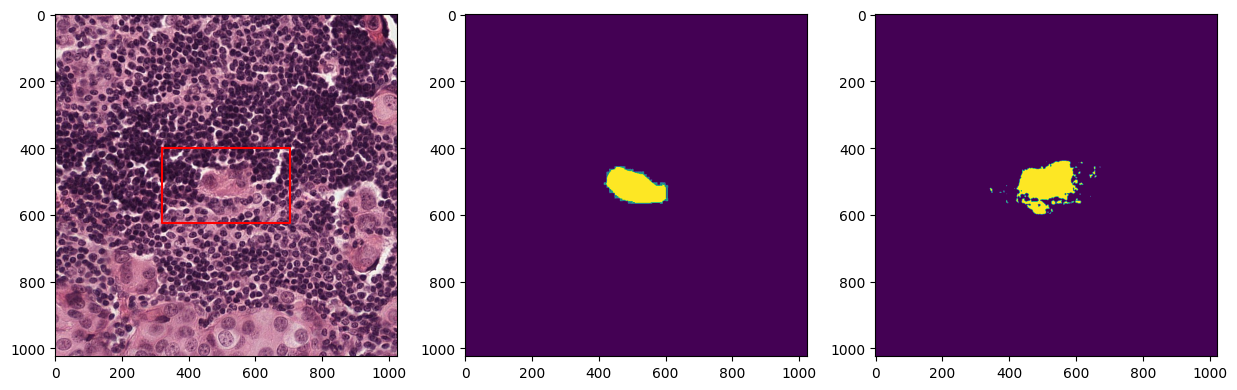

  0%|          | 12/2630 [00:12<45:07,  1.03s/it]

Dice score Image 11 : 0.698529411764706


  0%|          | 12/2630 [00:13<49:10,  1.13s/it]

[   0.    0. 1024. 1024.]


KeyboardInterrupt: 

In [2]:
def evaluate(predictor:SamPredictor, dataset:ChuAnapath, prompt_type:str='points'):
    '''Evaluate the model on the dataset'''
    dice_scores = []
    for i in tqdm(range(len(dataset))):
        img, mask, prompt = dataset[i]
        predictor.set_image(img)
        if prompt_type == 'points':
            prediction, _, _ = predictor.predict(prompt, np.ones(prompt.shape[0]), multimask_output=False)
        elif prompt_type == 'box':
            prediction, _, _ = predictor.predict(box=prompt, multimask_output=False)
        else:
            prediction, _, _ = predictor.predict(multimask_output=False)
        dice_scores.append(f1_score(np.array(prediction.flatten(), dtype=mask.dtype), mask.flatten()))
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        plt.axes(axes[0])
        plt.imshow(img)
        #plt.scatter(*prompt.T, c='r', s=5)
        print(prompt)
        # PLot box XYXY
        plt.plot([prompt[0], prompt[2], prompt[2], prompt[0], prompt[0]], [prompt[1], prompt[1], prompt[3], prompt[3], prompt[1]], c='r')
        axes[1].imshow(mask)
        axes[2].imshow(prediction.squeeze(0))
        plt.show()
        print(f'Dice score Image {i} : {dice_scores[-1]}')
    return dice_scores
dice_scores = evaluate(predictor, dataset, prompt_type)